In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import random
from copy import deepcopy
from matplotlib.animation import FuncAnimation

In [2]:
import layout

In [3]:
# Given a character, it returns the coordinates of the keys to be pressed
def get_coordinates(char, keys, characters):
    coords = []
    buttons = characters[char]
    for button in buttons:
        coords.append(keys[button]["pos"])
    return coords

# Calculates the total distance fingers have to move to press a certain character
def char_distance(char, keys, characters):
    buttons = characters[char]
    dist = 0
    for button in buttons:
        movement = keys[button]
        start_key = movement["start"]
        pos_start = keys[start_key]["pos"]
        pos_end = movement["pos"]
        dist += math.dist(pos_start, pos_end)
    return dist

In [4]:
# Calculates the frequency of different keys pressed
def calc_char_freq(para):
    char_freq = defaultdict(int)
    for char in para:
        if char != ' ':
            char_freq[char] += 1
    return char_freq

# Total distance travelled by the fingers
def total_distance(para, keys, characters):
    char_freq = calc_char_freq(para)
    tot_dist = 0
    for char in char_freq:
        tot_dist += char_distance(char, keys, characters) * char_freq[char]
    return tot_dist

# Creates a sort of 2D histogram for the heatmap plot
def calc_coord_freq(para, keys, characters):
    char_freq = calc_char_freq(para)
    coord_freq = defaultdict(int)
    for char in char_freq:
        coordinates = get_coordinates(char, keys, characters)
        for coordinate in coordinates:
            coord_freq[coordinate] += char_freq[char]
    return coord_freq

Swap function used to perform the Simulated Annealing

In [5]:
def get_neighbour(keys, characters):
    curr_keys, new_keys = deepcopy(keys), deepcopy(keys)
    key1, key2 = random.sample(list(curr_keys.keys()), 2)
    flag1, flag2 = (0, key1), (0, key2)

    if key1 in characters and len(characters[key1]) == 2:
        key1 = characters[key1][1]
    if key2 in characters and len(characters[key2]) == 2:
        key2 = characters[key2][1]

    new_keys[key1], new_keys[key2] = curr_keys[key2], curr_keys[key1]

    for key in curr_keys:
        if new_keys[key]['start'] == key1:
            new_keys[key]['start'] = 'buf'
    
    for key in curr_keys:
        if new_keys[key]['start'] == key2:
            new_keys[key]['start'] = key1

    for key in curr_keys:
        if new_keys[key]['start'] == 'buf':
            new_keys[key]['start'] = key2

    # This is to ensure special characters (@#$%...) are also swapped with their main characters (2345...)
    for key in curr_keys:
        if key in characters and len(characters[key]) == 2:
            if characters[key][1] == key1:
                new_keys[key] = new_keys[key1]
            if characters[key][1] == key2:
                new_keys[key] = new_keys[key2]

    return new_keys

In [6]:
def simulated_annealing(para, keys, characters, initial_temp, cooling_rate, num_iterations):
    current_keys = deepcopy(keys)
    current_distance = total_distance(para, current_keys, characters)
    
    best_keys = deepcopy(current_keys)
    best_distance = current_distance
    
    temp = initial_temp
    distances = [current_distance]
    best_keys_list = [best_keys.copy()]
    best_distances = [best_distance]

    for i in range(num_iterations):
        neighbour_keys = get_neighbour(current_keys, characters)
        neighbour_distance = total_distance(para, neighbour_keys, characters)
        
        p = np.exp((current_distance - neighbour_distance) / temp)

        if neighbour_distance < current_distance or random.random() < p:
            current_keys = deepcopy(neighbour_keys)
            current_distance = neighbour_distance
            
            if current_distance < best_distance:
                best_keys = deepcopy(current_keys)
                best_distance = current_distance
        
        temp *= cooling_rate
        distances.append(current_distance)
        best_keys_list.append(deepcopy(best_keys))
        best_distances.append(best_distance)

    return best_keys_list, best_distances, distances

Heatmap code from Assignment 4

In [7]:
def plot_heatmap(para, keys, characters):
    # Creating a sort of histogram for the heatmap
    coord_freq = calc_coord_freq(para, keys, characters)

    # Defining the bounds of the keyboard
    x_max = max(value["pos"][0] for value in keys.values())
    x_min = min(value["pos"][0] for value in keys.values())
    y_max = max(value["pos"][1] for value in keys.values())
    y_min = min(value["pos"][1] for value in keys.values())


    # Required to get a proper looking plot
    resolution = 0.5
    buffer = 1
    x_coords = np.arange(x_min - buffer, x_max + buffer + resolution, resolution)
    y_coords = np.arange(y_min - buffer, y_max + buffer + resolution, resolution)

    # Creating a frequency grid which is used to make the heatmap
    grid = np.zeros((len(y_coords), len(x_coords)))

    for (x, y), freq in coord_freq.items():
        x_idx = np.abs(x_coords - x).argmin()
        y_idx = np.abs(y_coords - y).argmin()
        grid[y_idx, x_idx] = freq


    plt.figure(figsize=(10, 5))

    # Assuming the inter key spacing is at least 1x1
    key_width = 0.9
    key_height = 0.9

    # Creating an object for each key
    for key in keys:
        x, y = keys[key]["pos"]
        if x is not None and y is not None:
            rect = plt.Rectangle(
                (x - key_width / 2, y - key_height / 2),
                key_width,
                key_height,
                edgecolor="black",
                facecolor="none",
            )
            plt.gca().add_patch(rect)
            if key in [
                "~", "!", "@", "#", "$", "%", "^", "&", "*", "(", ")", "_", "+", "{", "}", ":", '"', "<", ">", "?",
            ]:
                plt.text(
                    x - key_width / 4,
                    y + key_height / 4,
                    key,
                    fontsize=7,
                    ha="center",
                    va="center",
                )
            else:
                plt.text(x, y, key, fontsize=9, ha="center", va="center")

    # Making the Heatmap
    plt.imshow(
        grid,
        cmap="jet",
        interpolation="bilinear",
        extent=[x_min - 1, x_max + 1, y_min - 1, y_max + 1],
        origin="lower",
        alpha=0.5,
    )
    plt.colorbar(label="Frequency")

    # Finally Plotting
    plt.xlim(x_min - buffer, x_max + buffer)
    plt.ylim(y_min - buffer, y_max + buffer)
    plt.title("Keyboard with Heatmap Overlay")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [20]:
def plot_distances(best_distances, distances):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, len(distances) - 1)
    ax.set_ylim(min(distances) * 0.9, max(distances) * 1.1)

    ax.plot(range(len(best_distances)), best_distances, 'r-')
    ax.plot(range(len(distances)), distances, 'g-')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Distance')
    ax.set_title('Simulated Annealing: Best and Current Distance Over Iterations')

    plt.show()

### Main Section

Example para, can be modified to any arbitrary string

In [9]:
para = "The rain in Spain falls mainly on the plain. Each letter in this text appears at varying frequencies. The quick brown fox is just a phrase"

In [10]:
keys = deepcopy(layout.keys)
characters = layout.characters
initial_temp = 100
cooling_rate = 0.995
num_iterations = 2000

best_keys_list, best_distances, distances = simulated_annealing(para, keys, characters, initial_temp, cooling_rate, num_iterations)

### qwerty Keyboard Heatmap

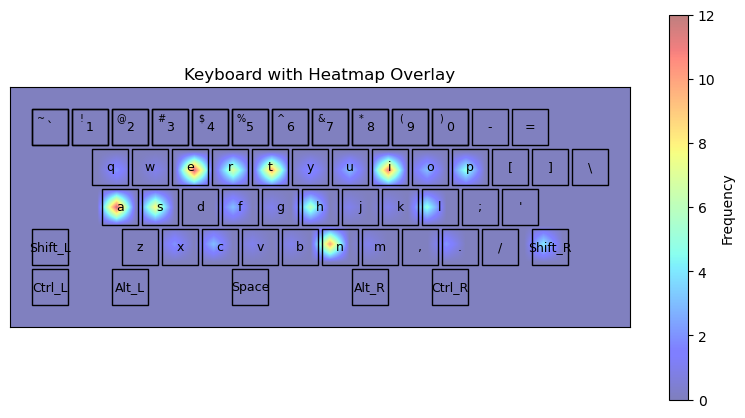

In [11]:
plot_heatmap(para, best_keys_list[0], characters)

### Optimised Keyboard Heatmap

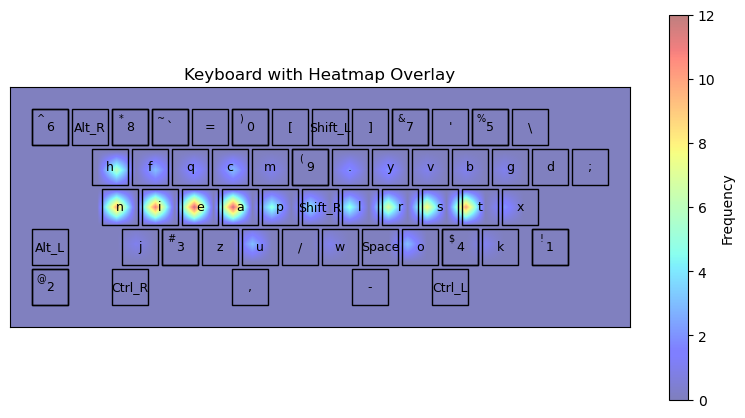

In [12]:
plot_heatmap(para, best_keys_list[-1], characters)

### Distance Plot

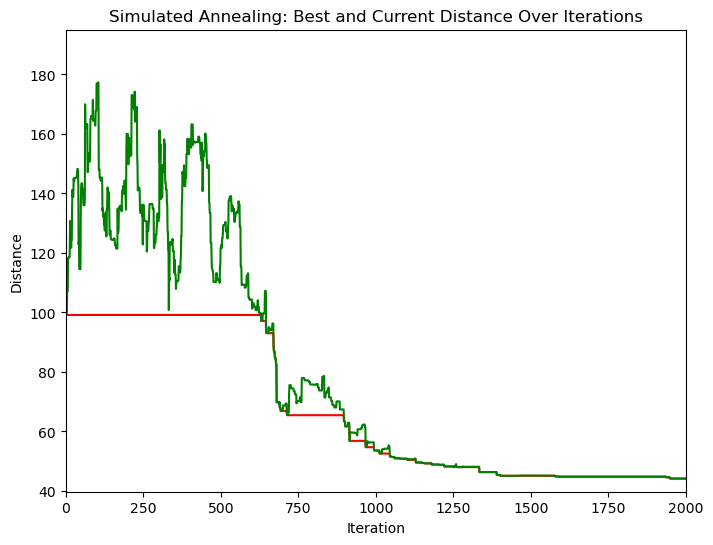

In [21]:
plot_distances(best_distances, distances)

### Distance Optimised

In [16]:
print('Original total distance:', best_distances[0])
print('Optimised total distace:', best_distances[-1])

Original total distance: 99.16340317278923
Optimised total distace: 44.177834026837346
